## **Business Problem**

**Background of the Problem:** <br/>
Indonesian telecommunications company (Indo Telco) operates in the telecommunications industry, providing various services and technologies that enable communication between individuals and companies. Despite having been established for over 20 years, Indo Telco faces the issue of customer churn, where customers switch to other service providers, resulting in the loss of customers for Indo Telco. The problem of customer churn is critical because it negatively impacts the company's revenue and reputation. Therefore, Indo Telco wants to understand the factors that lead customers to churn in order to design appropriate strategies to retain customers and simultaneously save on marketing costs.

**Problem Statement:** <br/>
The company wants to identify which customers are likely to churn in the future and understand the factors that cause customers to churn, as the company aims to allocate marketing costs carefully to save on marketing expenditures, since revenue is also a major concern.

**Objectives Analysis/Goals:** <br/>
To build a machine learning model that can identify customers likely to churn and analyze the factors that cause customers to churn. This aims to enable the company to allocate time and resources effectively and efficiently.

Target: <br/>
1 (Positive): Customer churn <br/>
0 (Negative): Customer tidak churn

**Analytic Approach:** <br/>
Analyze the data, then select and build a classification machine learning model that can predict customers likely to churn.

**Metric Evaluation:** <br/>
- Type 1 error (False Positive):
    - Interpretation: Incorrectly predicting that a customer will churn (when they actually will not churn).
    - Consequence: Financial loss due to offering special deals to customers who are not actually at risk of churning.

- Type 2 error (False Negative): 
    - Interpretation: Incorrectly predicting that a customer will not churn (when they actually will churn).
    - Consequence: Loss of customers due to not offering special deals to customers who are actually at risk of churning.

Given the company's problem, the model built must minimize Type 2 error (False Negative), because losing customers incurs a higher cost compared to the cost of offering special deals. In other words, errors resulting from FN (losing customers) are more detrimental than FP (incurring the cost of special offers).

As for the metric, ROC AUC is chosen as the main metric because the model can be threshold-tuned to achieve an optimal balance between True Positive Rate (Recall) and False Positive Rate, and to adjust the score to best suit the business problem.

Since the main goal in this case is to minimize the loss of customers (False Negatives), the modeling will focus on achieving a high Recall score to minimize undetected customer loss.

## **Data Understanding**

**Importing Libraries and Dataset**

**Dataset:**

| Feature |  Description |
| --- | --- | 
| Dependents | Whether the customer has dependents or not | 
| Tenure | Number of months the customer has stayed with the company | 
| OnlineSecurity | Whether the customer has online security or not |
| OnlineBackup | Whether the customer has online backup or not | 
| InternetService | Whether the client is subscribed to Internet service |
| DeviceProtection | Whether the client has device protection or not | 
| TechSupport | Whether the client has tech support or not  | 
| Contract | Type of contract according to duration | 
| PaperlessBilling | Bills issued in paperless form | 
| MonthlyCharges | Amount of charge for service on monthly bases in dollar | 
| Churn | Whether the customer churns or not | 

In [80]:
# import library 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pylab as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import RobustScaler
import category_encoders as ce

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as imbpipeline

import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import RocCurveDisplay

import shap

# load dataset
df = pd.read_csv('data_telco_customer_churn.csv')
df.head()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No


In [81]:
# brief overview of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [82]:
# brief overview of descriptive statistics of the dataset
print('Descriptive Stats for Number')
display(df.describe(include='number'))
print('Descriptive Stats for Object')
display(df.describe(include='object'))

Descriptive Stats for Number


,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


Descriptive Stats for Object


,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4930,4930,4930,4930,4930,4930,4930,4930,4930
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3446,2445,2172,2172,2186,2467,2721,2957,3614


In [83]:
# identifying values in each categorical column
pd.set_option('display.max_colwidth', 1)
colls = ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']

x = []
for i in colls:
    x.append( [i, df[i].nunique(), df[i].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'], data=x)
tabel1Desc

,Column Name,Number of Unique,Unique Sample
0,Dependents,2,"[Yes, No]"
1,OnlineSecurity,3,"[No, Yes, No internet service]"
2,OnlineBackup,3,"[No, Yes, No internet service]"
3,InternetService,3,"[DSL, Fiber optic, No]"
4,DeviceProtection,3,"[Yes, No internet service, No]"
5,TechSupport,3,"[Yes, No, No internet service]"
6,Contract,3,"[Month-to-month, Two year, One year]"
7,PaperlessBilling,2,"[Yes, No]"


In [84]:
# identifying columns with missing values
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

In [85]:
# identifying the distribution of the 'Churn' label
df['Churn'].value_counts()

Churn
No     3614
Yes    1316
Name: count, dtype: int64

> Insight summary dataset:
> - The dataset consists of 4,930 rows and 11 columns.
> - There are zero values in the tenure column.
> - The target value in the Churn column indicates an imbalance.
> - No duplicated data is detected, so no action is needed for handling duplicated data.
> - No missing values are detected, so no action is needed for handling missing values.

## **Exploratory Data Analysis**

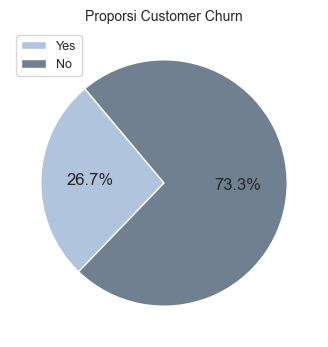

In [86]:
# identifying the percentage of customers who churn and who do not churn
plt.figure(figsize=(4, 4))

churn = df[df['Churn'] == 'Yes']
not_churn = df[df['Churn'] == 'No']
percentage_churn = len(churn) / len(df) * 100
percentage_not_churn = len(not_churn) / len(df) * 100

labels = ['Yes', 'No']
sizes = [percentage_churn, percentage_not_churn]
colors = ['lightsteelblue','slategrey']
patches, texts, autotexts = plt.pie(sizes, labels=None, colors=colors, autopct='%1.1f%%', startangle=130)
plt.legend(patches, labels, loc="upper left", fontsize=9)
plt.title('Proporsi Customer Churn', fontsize=10)
plt.show()

> As we can see from pie chart above there are 26.7% of customers that indicated as churn or switch to another service provider.

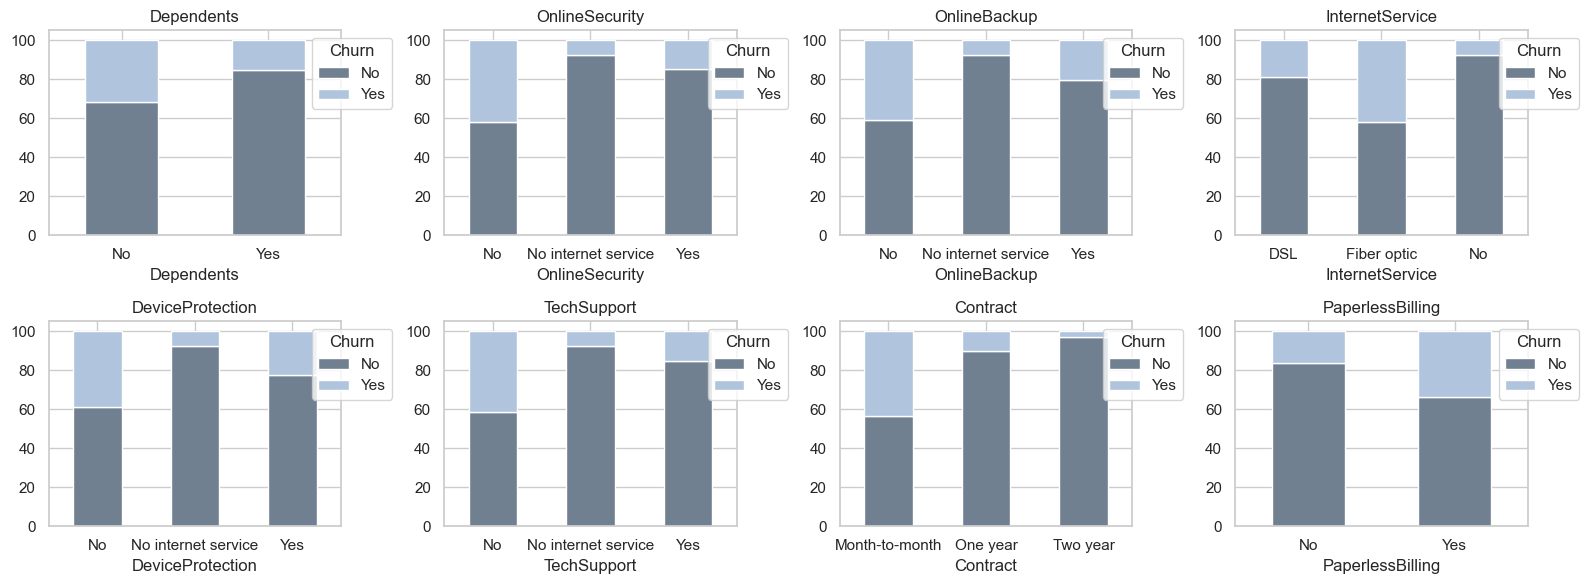

In [87]:
# identifying the comparison of churned customers in each categorical column
categorical_columns = ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 6))
colors = ['slategrey', 'lightsteelblue']
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    count_data = df.groupby([column, 'Churn']).size().unstack()
    churn_percentage = (count_data.T / count_data.T.sum()).T * 100
    churn_percentage.plot(kind='bar', stacked=True, ax=axes[i], color=colors)
    axes[i].set_title(f'{column}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0) 
    axes[i].legend(title='Churn', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.tight_layout()
plt.show()

> - In the `Dependents` column, customers who tend to churn are those who do not have dependents.
> - In the `OnlineSecurity` column, customers who tend to churn are those who do not use online security services.
> - In the `OnlineBackup` column, customers who tend to churn are those who do not use online backup services.
> - In the `InternetService` column, customers who tend to churn are those who use Fiber Optic internet service, while customers who do not churn are more inclined towards DSL service.
> - In the `DeviceProtection` column, customers who tend to churn are those who do not use device protection services.
> - In the `TechSupport` column, customers who tend to churn are those who do not use tech support services.
> - In the `Contract` column, customers who tend to churn are those who subscribe on a month-to-month basis.
> - In the `PaperlessBilling` column, customers who tend to churn are those who use paperless billing or prefer electronic billing.

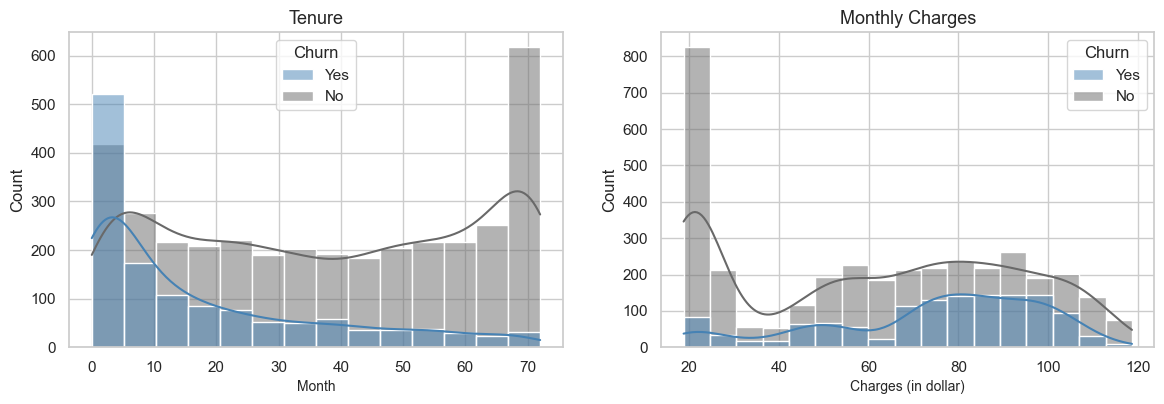

In [88]:
# identifying the comparison of churned customer in each numeric column
plt.figure(figsize=(14,9))
colors = ['steelblue', 'dimgrey']

plt.subplot(221)
sns.histplot(data=df,x='tenure',hue='Churn',kde=True, palette=colors)
plt.title('Tenure',fontsize=13)
plt.xlabel('Month', fontsize=10)

plt.subplot(222)
sns.histplot(data=df,x='MonthlyCharges',hue='Churn',kde=True, palette=colors)
plt.title('Monthly Charges',fontsize=13)
plt.xlabel('Charges (in dollar)', fontsize=10)
plt.show()

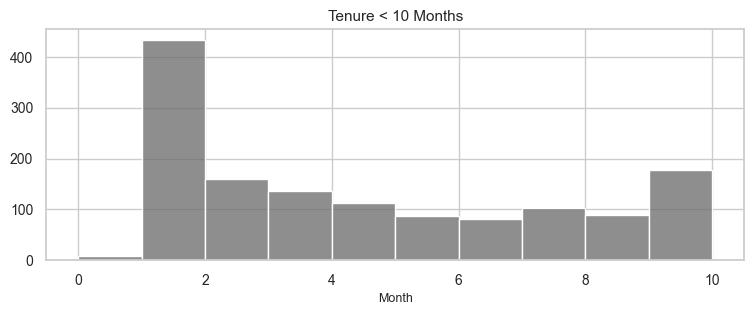

In [89]:
# visualizing the distribution of the tenure column by filtering < 10 months to see the frequency of months with the highest churn rate
plt.figure(figsize=(9, 3))
filtered_tenure = df[df['tenure'] < 11]
sns.histplot(filtered_tenure['tenure'], edgecolor='white', binwidth=1, color='dimgrey')
plt.title('Tenure < 10 Months', fontsize=11)  
plt.xlabel('Month', fontsize=9)
plt.ylabel('', fontsize=11)
plt.tick_params(axis='both', labelsize=10)
plt.show()

> - In the histogram of the `tenure` column, it can be observed that customers who are prone to churn are those who are new subscribers, subscribing for around 1 month, and then there are fewer subscriptions in the subsequent months.
> - In the histogram of the `MonthlyCharges` column, a pattern emerges indicating that higher monthly charges make customers more susceptible to churn. Customers with charges greater than $60 are more likely to churn.

## **Data Cleaning**

**Handling Zero Values**

In [90]:
# identofying zero values 
colls = ['tenure']
condition = (df[colls] == 0)
zero_val = df[condition.any(axis=1)]
total_zero_count = len(zero_val)
print(f'The number of rows with zero values overall: {total_zero_count}')
total_entries = len(df)
zero_percentage = (total_zero_count / total_entries) * 100
print(f'The proportion of zero values overall: {zero_percentage}')

df[df['tenure'] == 0]

The number of rows with zero values overall: 8
The proportion of zero values overall: 0.16227180527383367


,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
82,Yes,0,No,Yes,DSL,Yes,Yes,Two year,No,73.35,No
325,Yes,0,Yes,No,DSL,Yes,Yes,Two year,Yes,52.55,No
1053,Yes,0,No internet service,No internet service,No,No internet service,No internet service,Two year,No,25.35,No
2017,Yes,0,Yes,Yes,DSL,Yes,No,Two year,No,80.85,No
2902,Yes,0,Yes,Yes,DSL,No,Yes,Two year,Yes,61.90,No
3410,Yes,0,Yes,Yes,DSL,Yes,Yes,Two year,No,56.05,No
4192,Yes,0,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.25,No
4441,Yes,0,No internet service,No internet service,No,No internet service,No internet service,Two year,No,19.85,No


In [91]:
# deleting zero values
df = df.loc[~(df['tenure'] == 0)].reset_index(drop=True)

> Deleting zero values in the `tenure` column because they are considered contradictory to the descriptive column, which is assumed to be a data entry error, hence needs to be removed. The relatively small proportion is also considered in deleting zero values and deemed not to significantly affect the information or conclusions that can be drawn from the data.

**Identifying Outliers**

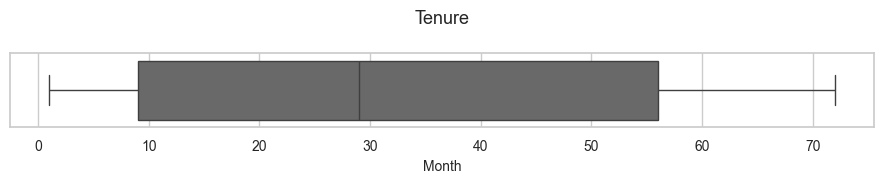

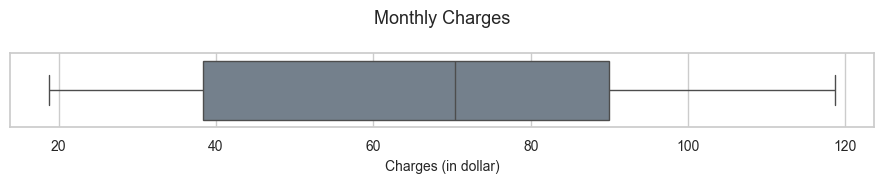

In [92]:
# identifying outliers in the `tenure` column
fig, ax = plt.subplots(figsize=(9, 2))
boxplot = sns.boxplot(x=df['tenure'], color='dimgrey')
boxplot.set_title('Tenure\n', fontsize=13)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel('Month', fontsize=10)
plt.tight_layout()
plt.show()

# identifying outliers in the `MonthlyCharges` column	
fig, ax = plt.subplots(figsize=(9, 2))
boxplot = sns.boxplot(x=df['MonthlyCharges'], color='slategrey')
boxplot.set_title('Monthly Charges\n', fontsize=13)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlabel('Charges (in dollar)', fontsize=10)
plt.tight_layout()
plt.show()

> No outliers are indicated in the `tenure` and `MonthlyCharges` columns, so no action is needed for handling outliers.

## **Preprocessing**

**Data Splitting**

In [93]:
# converting the target variable/column `Churn` to numeric 
label_encoder = LabelEncoder()
df['Churn'] = label_encoder.fit_transform(df['Churn'])

# splitting the dataset into training and validation data
X = df.drop('Churn',axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

**Transform Data**

In [106]:
# mapping process for the `Contract` column
contracts = ['Month-to-month', 'Two year', 'One year']

# encoding and transforming for X_train, and transforming for the 
preprocessor = ColumnTransformer([
            ('onehot', OneHotEncoder(), ['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'PaperlessBilling']),
            ('ordinal', OrdinalEncoder(categories=[contracts]), ['Contract']),
            ('scaller', RobustScaler(), ['tenure', 'MonthlyCharges'])
            ])

preprocessor.fit(X_train)

feature_names = preprocessor.get_feature_names_out()
X_train_trans = pd.DataFrame(preprocessor.transform(X_train), columns=feature_names)
X_test_trans = pd.DataFrame(preprocessor.transform(X_test), columns=feature_names)

X_train_trans.head()

,onehot__Dependents_No,onehot__Dependents_Yes,onehot__OnlineSecurity_No,onehot__OnlineSecurity_No internet service,onehot__OnlineSecurity_Yes,onehot__OnlineBackup_No,onehot__OnlineBackup_No internet service,onehot__OnlineBackup_Yes,onehot__InternetService_DSL,onehot__InternetService_Fiber optic,...,onehot__DeviceProtection_No internet service,onehot__DeviceProtection_Yes,onehot__TechSupport_No,onehot__TechSupport_No internet service,onehot__TechSupport_Yes,onehot__PaperlessBilling_No,onehot__PaperlessBilling_Yes,ordinal__Contract,scaller__tenure,scaller__MonthlyCharges
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.446809,-0.477654
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.361702,-0.932961
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,0.021277,-0.025140
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,-0.595745,-0.361266
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.297872,0.290503


**Handling Imbalance Data**

In [95]:
# calculating the imbalance ratio
churn_counts = df['Churn'].value_counts()
ratio = churn_counts[0] / churn_counts[1]
print(f'Imbalance ratio: {ratio}')

Imbalance ratio: 2.7401215805471124


> - The ratio above indicates that the majority class (not churn) has approximately 2.74 times more samples than the minority class (churn). Therefore, it can be said that the data has a significant level of imbalance, requiring imbalance data handling.
> - In this case, we're going to use SMOTEEN methods to handle the imbalance data.

In [96]:
# handling imbalance data
print(f'Before resample: {y_train.value_counts()}\n') 

smoteenn = SMOTEENN(random_state=42)
pipeline = imbpipeline(steps=[
    ('preprocessor', preprocessor),
    ('smoteenn', smoteenn)
])

X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=feature_names)

print(f'After resample: {y_train_resampled.value_counts()}\n') 

Before resample: Churn
0    2884
1    1053
Name: count, dtype: int64

After resample: Churn
0    1681
1    1616
Name: count, dtype: int64



## **Modeling**

**Choosing Baseline Model**

In [97]:
# the benchmark model that will be used
models = [
    ['LGBM', lgb.LGBMClassifier(verbosity=-1, random_state=42)],
    ['CatBoost', CatBoostClassifier(verbose=0, random_state=42)],
    ['XGBoost', xgb.XGBClassifier(random_state=42)],
    ['SVC', SVC(verbose=0, random_state=42)],
    ['Random Forest', RandomForestClassifier(random_state=42)],
    ['GradientBoost', GradientBoostingClassifier(random_state=42)]
]

In [98]:
# comparing training score between resampled and not resampled data

scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

# training score without resampled data 
results_without_resample = []
for name, model in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results_without_resample.append([
        name,
        np.mean(scores['test_roc_auc']),
        np.mean(scores['test_f1']),
        np.mean(scores['test_recall']),
        np.mean(scores['test_precision'])
    ])
    
df_without_resample = pd.DataFrame(results_without_resample, columns=['Model', 'ROC AUC', 'F1', 'Recall', 'Precision']).set_index('Model')
print("Training score without resampled data:")
display(df_without_resample)


# training score with resampled data 
smote = SMOTEENN(random_state=42)
results_with_resample = []
for name, model in models:
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])
    scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=5, n_jobs=-1)
    results_with_resample.append([
        name,
        np.mean(scores['test_roc_auc']),
        np.mean(scores['test_f1']),
        np.mean(scores['test_recall']),
        np.mean(scores['test_precision'])
    ])

df_with_resample = pd.DataFrame(results_with_resample, columns=['Model', 'ROC AUC', 'F1', 'Recall', 'Precision']).set_index('Model')
print("\nTraining score with resampled data:")
display(df_with_resample)

Training score without resampled data:


,ROC AUC,F1,Recall,Precision
Model,,,,
LGBM,0.821689,0.551277,0.501462,0.612139
CatBoost,0.834402,0.574044,0.518574,0.643436
XGBoost,0.807414,0.553845,0.514755,0.599659
SVC,0.797865,0.535382,0.461553,0.637560
Random Forest,0.790238,0.519130,0.464450,0.588952
GradientBoost,0.836219,0.572553,0.515703,0.644717



Training score with resampled data:


,ROC AUC,F1,Recall,Precision
Model,,,,
LGBM,0.828788,0.621641,0.737937,0.537229
CatBoost,0.832610,0.619330,0.752182,0.526622
XGBoost,0.822679,0.619397,0.734114,0.535970
SVC,0.820194,0.604023,0.759720,0.501673
Random Forest,0.818003,0.621479,0.741711,0.534841
GradientBoost,0.833322,0.625117,0.767362,0.527782


> After resampling using the SMOTEENN method, it can be seen that the models trained on the resampled data are better at identifying instances of the minority class while maintaining a balance between precision and recall. Therefore, for the next process, we will use the resampled data.

**Model Baseline: Test Validation Data**

In [99]:
# test validation score with resampled data 
results_test_with_resample = []

for name, model in models:
    pipeline = imbpipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', smote),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)  
    y_pred_test = pipeline.predict(X_test)
    
    roc_auc = roc_auc_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)

    results_test_with_resample.append([name, roc_auc, f1, recall, precision])

df_test_with_resample = pd.DataFrame(results_test_with_resample, columns=['Model', 'ROC AUC', 'F1', 'Recall', 'Precision']).set_index('Model')
print("\nTest validation score with resampled data:")
display(df_test_with_resample)



Test validation score with resampled data:


,ROC AUC,F1,Recall,Precision
Model,,,,
LGBM,0.766994,0.637224,0.768061,0.544474
CatBoost,0.773377,0.642089,0.794677,0.538660
XGBoost,0.773906,0.644757,0.783270,0.547872
SVC,0.760735,0.624071,0.798479,0.512195
Random Forest,0.770797,0.641509,0.775665,0.546917
GradientBoost,0.774396,0.639881,0.817490,0.525672


> The LGBM and SVC models have the lowest scores, therefore, for the next steps, we will only use the `CatBoost`, `XGBoost`, `Random Forest`, and `GradientBoost` models.

**Voting Classifier Experiment** <br/>
This is an experimental process to determine whether the model, after ensembling, produces better scores/performance or not

In [101]:
estimators = [
        ('CatBoost', CatBoostClassifier(verbose=0, random_state=42)),
        ('XGBoost', xgb.XGBClassifier(random_state=42)),
        ('Random Forest', RandomForestClassifier(random_state=42)),
        ('GradientBoost', GradientBoostingClassifier(random_state=42))
        ]

vc_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('voting', VotingClassifier(estimators, voting='soft'))
])

# training score with voting classifier
vc_pipeline.fit(X_train, y_train)

y_pred_train_proba = vc_pipeline.predict_proba(X_train)[:, 1]
y_pred_train = (y_pred_train_proba >= 0.5).astype(int)

roc_auc_train = roc_auc_score(y_train, y_pred_train_proba)
f1_train = f1_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train)

results_train = pd.DataFrame({'Model': ['Voting Classifier'],
                              'ROC AUC': [roc_auc_train],
                              'F1': [f1_train],
                              'Recall': [recall_train],
                              'Precision': [precision_train]}).set_index('Model')

print('Training score dengan Voting Classifier:')
display(results_train)


# test validation score with voting classifier
y_pred_test_proba = vc_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_pred_test_proba >= 0.5).astype(int)

roc_auc_val = roc_auc_score(y_test, y_pred_test_proba)
f1_val = f1_score(y_test, y_pred_test)
recall_val = recall_score(y_test, y_pred_test)
precision_val = precision_score(y_test, y_pred_test)

results_val = pd.DataFrame({'Model': ['Voting Classifier'],
                            'ROC AUC': [roc_auc_val],
                            'F1': [f1_val],
                            'Recall': [recall_val],
                            'Precision': [precision_val]}).set_index('Model')

print('\nTest validation score dengan Voting Classifier:')
display(results_val)

Training score dengan Voting Classifier:


,ROC AUC,F1,Recall,Precision
Model,,,,
Voting Classifier,0.869208,0.673298,0.835708,0.563741



Test validation score dengan Voting Classifier:


,ROC AUC,F1,Recall,Precision
Model,,,,
Voting Classifier,0.846676,0.647059,0.794677,0.545692


> It turns out that after using the ensemble method with the Voting Classifier, there was an increase in the ROC AUC score compared to the Random Forest model (the model with the highest score before ensembling), even though it was small. Therefore, the Voting Classifier model with `XGBoost`, `Random Forest`, `LightGBM`, and `SVC` estimators using soft voting will be used as the final model.

In [102]:
# voting classifier pipeline
vc_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Dependents',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'InternetService',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'PaperlessBilling']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Month-to-month',
                                                                              'Two '
                                                                              'year',
                                                                              'One '
                                                                              'year']]),
                                                  ['Contract']),
                                                 ('scaller', RobustScaler(),
                                                  ['tenure',
                                                   'MonthlyC...
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...)),
                                              ('Random Forest',
                                               RandomForestClassifier(random_state=42)),
                                              ('GradientBoost',
                                               GradientBoostingClassifier(random_state=42))],
                                  voting='soft'))])

              precision    recall  f1-score   support

           0       0.91      0.76      0.83       722
           1       0.55      0.79      0.65       263

    accuracy                           0.77       985
   macro avg       0.73      0.78      0.74       985
weighted avg       0.81      0.77      0.78       985



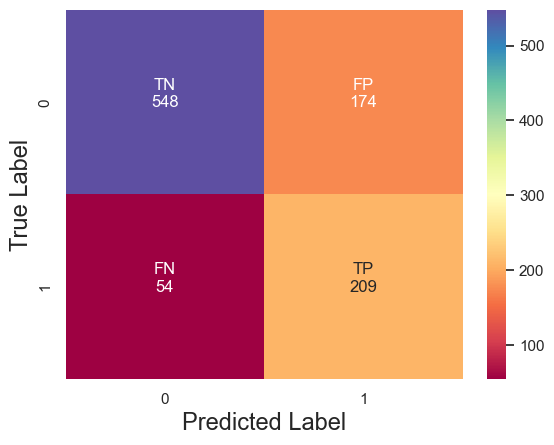

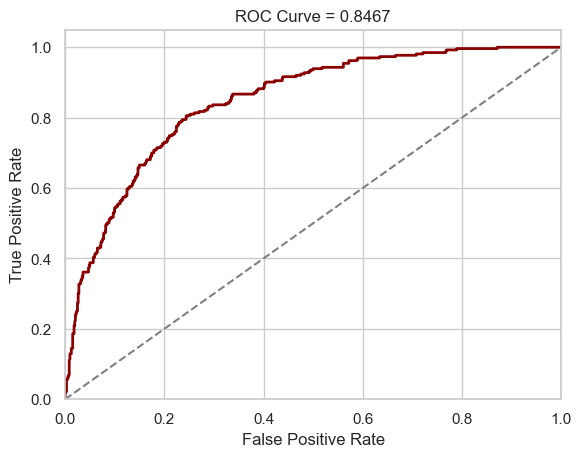

In [103]:
# classification report and confusion matrix  
vc_pipeline.fit(X_train, y_train)

print(classification_report(y_test, vc_pipeline.predict(X_test)))

cm = confusion_matrix(y_test, vc_pipeline.predict(X_test))
names = ['TN','FP','FN','TP']
counts = [value for value in cm.flatten()]
labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(names,counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, cmap='Spectral', fmt='')
plt.xlabel('Predicted Label', fontsize=17)
plt.ylabel('True Label', fontsize=17)
plt.show()

# ploting ROC AUC curve model ensamble
y_pred_proba = vc_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve = {roc_auc:.4f}')
plt.show()

**Probability Threshold Tuning** <br/>
Since the main goal in this case is to minimize customer loss (False Negatives), the probability threshold tuning process will focus on achieving a high Recall score to minimize undetected customer loss.

              precision    recall  f1-score   support

           0       0.93      0.66      0.77       722
           1       0.48      0.86      0.62       263

    accuracy                           0.72       985
   macro avg       0.71      0.76      0.70       985
weighted avg       0.81      0.72      0.73       985



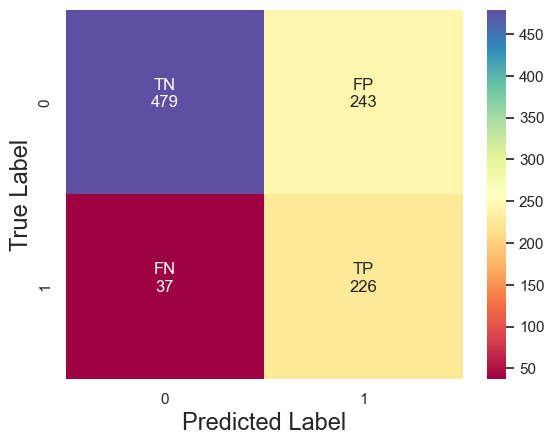

In [104]:
y_pred_proba = vc_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.2).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
names = ['TN','FP','FN','TP']
counts = [value for value in cm.flatten()]
labels = [f'{v1}\n{v2}\n' for v1, v2 in zip(names,counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, cmap='Spectral', fmt='')
plt.xlabel('Predicted Label', fontsize=17)
plt.ylabel('True Label', fontsize=17)
plt.show()

> After performing probability threshold tuning, there was a significant change in scores between the classification report and confusion matrix.

**How the Final Model Algorithm Works**

The final model is a Voting Classifier, which is a combination of several models as estimators consisting of XGBoost, Random Forest, LightGBM, and Support Vector Classifier that have previously undergone hyperparameter tuning.

The voting method used is "soft," which provides probability predictions for each class. Then, the probability predictions from each estimator are normalized and weighted. These weights can be determined based on the confidence score of each model. The final prediction is the result of combining the probability predictions from each estimator, where the weight of each estimator influences the final score.

A threshold of 0.2 is chosen to classify the probability prediction results into binary classes (0 or 1). This means that if the prediction probability is greater than or equal to 0.2, the result will be considered as class 1 (churn), and if it is less than 0.2, the result will be considered as class 0 (not churn). The selection of this threshold is based on testing multiple thresholds until finding the appropriate choice to achieve a score that aligns with the business problem/goals defined at the beginning (minimizing FN/increasing Recall score).

**Shapley Additive Explanations (SHAP)**

PermutationExplainer explainer: 986it [4:03:27, 14.84s/it]                           


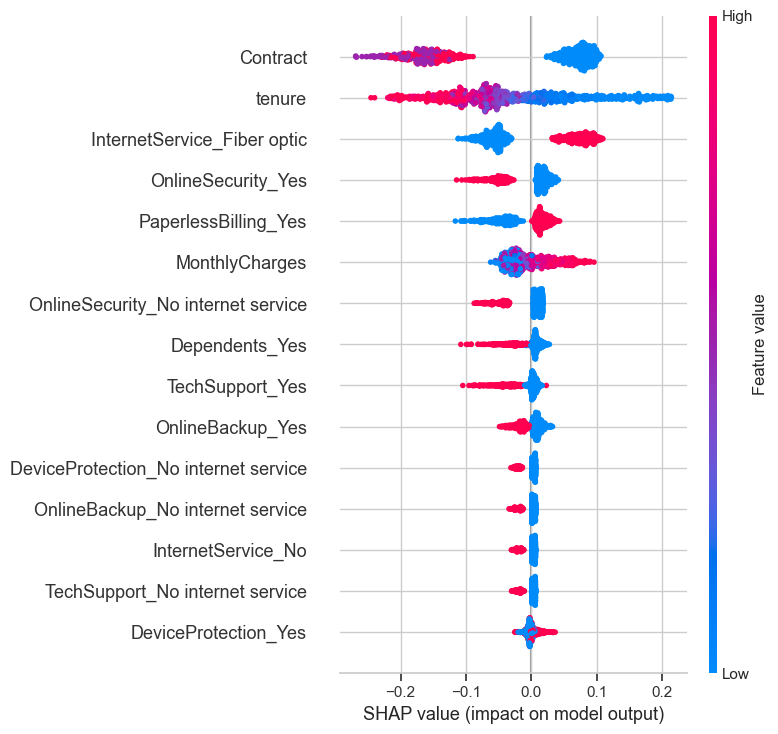

In [ ]:
# visualisasi SHAP
explainer = shap.Explainer(vc_best.predict_proba, X_train_resampled)
shap_values = explainer(X_val_final)
shap.summary_plot(shap_values[:, :, 1], X_val_final, plot_type="dot", show=False)

> SHAP Interpretation: <br/>
> - `tenure`: Customers who have been subscribed for a long time are less likely to churn.
> - `Contract`: The shorter the contract duration, the greater the likelihood of customer churn.
> - `MonthlyCharges`: The higher the charges, the greater the likelihood of customer churn.
> - `InternetService_Fiber` optic: Customers who choose Fiber Optic service are more likely to churn.
> - `OnlineSecurity_Yes`: Customers who choose Online Security service are less likely to churn.
> - `PaperlessBilling_Yes`: Customers who choose paperless billing service tend to have a higher likelihood of churn.
> - `TechSupport_Yes`: Customers who choose Tech Support service are less likely to churn.
> - `OnlineSecurity_No internet service:` Customers who do not choose Internet Service have a lower likelihood of churn.
> - `Dependents_Yes`: Customers who do not have dependents have a lower likelihood of churn.
> - `OnlineBackup_Yes`: Customers who choose Online Backup service are less likely to churn.
> - `DeviceProtection_No internet service`: Customers who do not choose No Internet Service for Device Protection have a lower likelihood of churn.
> - `InternetService_No`: Customers who do not choose Internet Service have a lower likelihood of churn.
> - `OnlineBackup_No internet service`: Customers who choose No Internet Service for Online Backup have a lower likelihood of churn.
> - `TechSupport_No internet service`: Customers who choose No Internet Service for Tech Support have a lower likelihood of churn.
> - `DeviceProtection_Yes`: Customers who choose Device Protection service are more likely to churn.
>
> Based on the modeling performed, the features tenure, Contract, and MonthlyCharges are highly influential features.

## **Conclusion**

Based on the classification report results from the chosen final model (Voting Classifier), it can be said that the model is able to predict customers who truly churn at a rate of **95%** (Recall) and is able to predict customers who churn from all positive classes at a rate of **41%** (Precision).

**Model Limitation** <br/>
This model has limitations regarding the range of data used. Here are the limitations:
- The `Dependents` and `PaperlessBilling` features have unique values "Yes" and "No".
- The `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, and `TechSupport` features have unique values "No", "Yes", and "No internet service".
- The `Contract` feature has unique values "Month-to-month", "Two year", and "One year".
- The `InternetService` feature has unique values "DSL", "Fiber optic", and "No".
- The `tenure` feature has a time range of 0 to 72 months.
- The `MonthlyCharges` feature has monthly charges ranging from 18 USD to 118 USD.

**Cost Saving Calculation**<br/>
Based on the source, the acquisition cost is five times greater than the retention cost. Similarly, losing a customer also leads to higher expenditures compared to retention cost. Let's compare the expenditure calculations with and without the model.


Based on the number of validation data, the total number of customers is **985**, with **263** churned customers and **722** non-churned customers. Previously, it was mentioned that the cost of losing a customer is five times greater, so the retention cost is set at **5 USD**, which means the acquisition cost is **25 USD**.

Retention cost = 5 <br/>
Acquisition cost = 25 <br/>

<u>Without Model</u> <br/>
(all customers indicated as churned will receive a special offer.)

Churned customer = 263 <br/>
Non-churned customer = 722 <br/>

- Total retention cost = 263 x 5 = 1.315
- Total acquisition cost = 263 x 25 = 6.575
- Total cost tanpa model = **7.890**

<u>With Model</u> <br/>
(only customers indicated as churned by the model will receive a special offer based on their individual conditions.)

FP = 364 (the number of customers predicted as positive/churned) <br/>
TP = 250 (the number of customers in the positive/churned class) <br/>
FN = 13 (the number of customers who actually churned) <br/>

- Total cost with model = (FP x 5) + (TP x 5) + (FN x 25)
- Total cost with model = (364 x 5) + (250 x 5) + (13 x 25)
- Total cost with model = 1.820 + 1.250 + 325
- Total cost dwith model = **3.395**

Using the built model, marketing expenditure becomes more efficient compared to without the model, as the model can predict churned customers in more detail. Therefore, the company, if using this model, can allocate expenditure more accurately, targeting customers who actually churn and those predicted to churn.


Source: <br/>
https://www.optimove.com/resources/learning-center/customer-acquisition-vs-retention-costs

## **Recommendation**

**Business Reccomendations:** <br/>
- **Adjust pricing strategy** for the services offered, as seen through the Monthly Charges feature where higher monthly charges tend to increase the likelihood of customer churn.
- **Enhance retention campaigns** to retain long-term customers, as indicated by the tenure feature showing that customers with longer service durations are less likely to churn.
- **Improve Fiber Optic services** in Internet Service, as seen through the Internet Service feature indicating that customers using Fiber Optic services are more likely to churn.
- **Enhance campaigns for customers with families**, as shown by the Dependents feature indicating that customers with dependents are less likely to churn.
- **Improve Device Protection services and launch educational campaigns about their importance**, as seen through the Device Protection feature showing that customers who are more likely to churn are those using Device Protection services. This could indicate dissatisfaction with the service provided or a lack of understanding of the value of Device Protection services, leading them to discontinue their use.

**Model Reccomendations:** <br/>
- **Adding features related to customer preferences** to better understand customer characteristics, such as payment method, gender, and age.
- **Using different ensemble model methods**, such as bagging, stacking, and boosting, to compare the performance of different methods with the method already applied, namely the voting classifier method.

**Save Model**

In [ ]:
# import pickle

# with open('vc.pkl', 'wb') as file:
#     pickle.dump(vc_best, file)